In [1]:
from dataclasses import dataclass

import numpy as np
import torch
import wandb
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from src.architectures.dvi import DVI
from src.components.cdvi.cmcd import CMCD
from src.components.cdvi.dis import DIS
from src.components.control.aggr_control import AggrControl
from src.components.control.bca_control import BCAControl
from src.components.control.mha_control import MHAControl
from src.components.encoder.aggr_encoder import Aggr, AggrEncoder
from src.components.encoder.bca_encoder import BCAEncoder
from src.components.encoder.mha_encoder import MHAEncoder
from src.components.schedule.annealing_schedule import (AggrAnnealingSchedule,
                                                        AnnealingSchedule,
                                                        BCAAnnealingSchedule)
                                                 
from src.components.schedule.cos_noise_schedule import (
    AggrCosineNoiseSchedule, BCACosineNoiseSchedule, CosineNoiseSchedule)
from src.components.schedule.noise_schedule import (AggrNoiseSchedule,
                                                    BCANoiseSchedule,
                                                    NoiseSchedule)
from src.components.schedule.step_size_schedule import StepSizeSchedule
from src.training.dvi_trainer import DVITrainerContext
from src.utils.datasets import ContextSetDataset
from src.utils.distros import TaskPosteriorGMM

In [2]:
# try:
#     import torch_directml
#     device = torch_directml.device() 
# except ImportError:
#     device = torch.device("cpu") 

device = torch.device("cpu") 

In [3]:
@dataclass
class Config():
    num_steps = 16
    c_dim = 2
    z_dim = 2
    h_dim = 32
    num_layers = 3
    non_linearity = "GELU"
    use_score = False
    learning_rate = 3e-3
    size = 64
    batch_size = 64

config = Config()

In [4]:
dataset = ContextSetDataset(size=config.size, c_dim=config.c_dim, max_context_size=10, sampling_factor=4)
dataloader = DataLoader(dataset=dataset, batch_size=config.batch_size, shuffle=True)

In [12]:
contextual_target = TaskPosteriorGMM

aggr_encoder = AggrEncoder(
    c_dim=config.c_dim,
    h_dim=config.h_dim,
    num_layers=config.num_layers,
    non_linearity=config.non_linearity,
    num_heads=None,
    aggregation=Aggr.MEAN,
    max_context_size=None, # dataset.max_context_size
)

bca_encoder = BCAEncoder(
    c_dim=config.c_dim,
    h_dim=config.h_dim,
    z_dim=config.z_dim,
    num_layers=config.num_layers,
    non_linearity=config.non_linearity,
    num_heads=None
)

mha_encoder = MHAEncoder(
    c_dim=config.c_dim,
    h_dim=config.h_dim,
    num_layers=config.num_layers,
    non_linearity=config.non_linearity,
    num_heads=1
)

aggr_control = AggrControl(
    h_dim=config.h_dim, 
    z_dim=config.z_dim, 
    num_steps=config.num_steps,
    num_layers=config.num_layers, 
    non_linearity=config.non_linearity, 
    use_score=config.use_score,
    use_error=False
)

bca_control = BCAControl(
    h_dim=config.h_dim, 
    z_dim=config.z_dim, 
    num_steps=config.num_steps,
    num_layers=config.num_layers, 
    non_linearity=config.non_linearity,
    use_score=config.use_score,
    use_error=False
)

mha_control = MHAControl(
    h_dim=config.h_dim, 
    z_dim=config.z_dim, 
    num_steps=config.num_steps,
    num_layers=config.num_layers, 
    non_linearity=config.non_linearity,
    use_score=config.use_score,
    num_heads=1
)

step_size_schedule = StepSizeSchedule(
    num_steps=config.num_steps, 
    device=device
)

noise_schedule = NoiseSchedule(
    z_dim=config.z_dim,
    num_steps=config.num_steps, 
    device=device,
)

aggr_noise_schedule = AggrNoiseSchedule(
    z_dim=config.z_dim,
    h_dim=config.h_dim,
    non_linearity=config.non_linearity,
    num_steps=config.num_steps, 
    device=device
)

bca_noise_schedule = BCANoiseSchedule(
    z_dim=config.z_dim,
    h_dim=config.h_dim,
    non_linearity=config.non_linearity,
    num_steps=config.num_steps, 
    device=device
)

# mha_noise_schedule = MHANoiseSchedule(
#     z_dim=config.z_dim,
#     h_dim=config.h_dim,
#     non_linearity=config.non_linearity,
#     num_steps=config.num_steps, 
#     device=device,
#     num_heads=1
# )

annealing_schedule = AnnealingSchedule(
    num_steps=config.num_steps, 
    device=device
)

aggr_annealing_schedule = AggrAnnealingSchedule(
    h_dim=config.h_dim,
    non_linearity=config.non_linearity,
    num_steps=config.num_steps, 
    device=device
)

bca_annealing_schedule = BCAAnnealingSchedule(
    h_dim=config.h_dim,
    non_linearity=config.non_linearity,
    num_steps=config.num_steps, 
    device=device
)

# mha_annealing_schedule = MHAAnnealingSchedule(
#     h_dim=config.h_dim,
#     non_linearity=config.non_linearity,
#     num_steps=config.num_steps, 
#     device=device,
#     num_heads=1
# )

cos_noise_schedule = CosineNoiseSchedule(
    z_dim=config.z_dim,
    num_steps=config.num_steps,
    device=device,
)

aggr_cos_noise_schedule = AggrCosineNoiseSchedule(
    z_dim=config.z_dim,
    h_dim=config.h_dim,
    non_linearity=config.non_linearity,
    num_steps=config.num_steps, 
)

bca_cos_noise_schedule = BCACosineNoiseSchedule(
    z_dim=config.z_dim,
    h_dim=config.h_dim,
    non_linearity=config.non_linearity,
    num_steps=config.num_steps, 
)

comps = (aggr_control, noise_schedule, annealing_schedule, aggr_encoder)
# comps = (aggr_control, aggr_noise_schedule, aggr_annealing_schedule, aggr_encoder)
# comps = (aggr_control, aggr_cos_noise_schedule, aggr_annealing_schedule, aggr_encoder)
# comps = (bca_control, noise_schedule, annealing_schedule, bca_encoder)
# comps = (bca_control, cos_noise_schedule, annealing_schedule, bca_encoder)
# comps = (bca_control, bca_noise_schedule, bca_annealing_schedule, bca_encoder)
# comps = (bca_control, bca_cos_noise_schedule, bca_annealing_schedule, bca_encoder)
# comps = (mha_control, mha_noise_schedule, mha_annealing_schedule, mha_encoder)

cdvi = DIS(
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    control=comps[0], 
    step_size_schedule=step_size_schedule,
    noise_schedule=comps[1],
    annealing_schedule=comps[2],
    use_score=config.use_score,
    use_error=False,
    device=device, 
)

# cdvi = CMCD(
#     z_dim=config.z_dim, 
#     num_steps=config.num_steps, 
#     control=comps[0],
#     step_size_schedule=step_size_schedule,
#     noise_schedule=comps[1],
#     annealing_schedule=comps[2],
#     device=device, 
# )

model = DVI(
    encoder=comps[3],
    cdvi=cdvi, 
    contextual_target=contextual_target
)

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

trainer = DVITrainerContext(
    model=model,
    device=device,
    dataset=dataset,
    train_loader=dataloader,
    val_loader=dataloader,
    optimizer=optimizer,
    scheduler=None,
    generator=torch.Generator(device=device),
    wandb_logging=False,
    num_subtasks=32,
    num_samples=32,
    val_grad_off=True
)

In [15]:
trainer.wandb_logging = False
if trainer.wandb_logging:
    wandb.init(project="local-toytask", name="bca")

In [16]:
num_epochs = 3000

losses = trainer.train(
    num_epochs=num_epochs,
    max_clip_norm=None,
    alpha=None
)

  0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (64) must match the size of tensor b (32) at non-singleton dimension 1

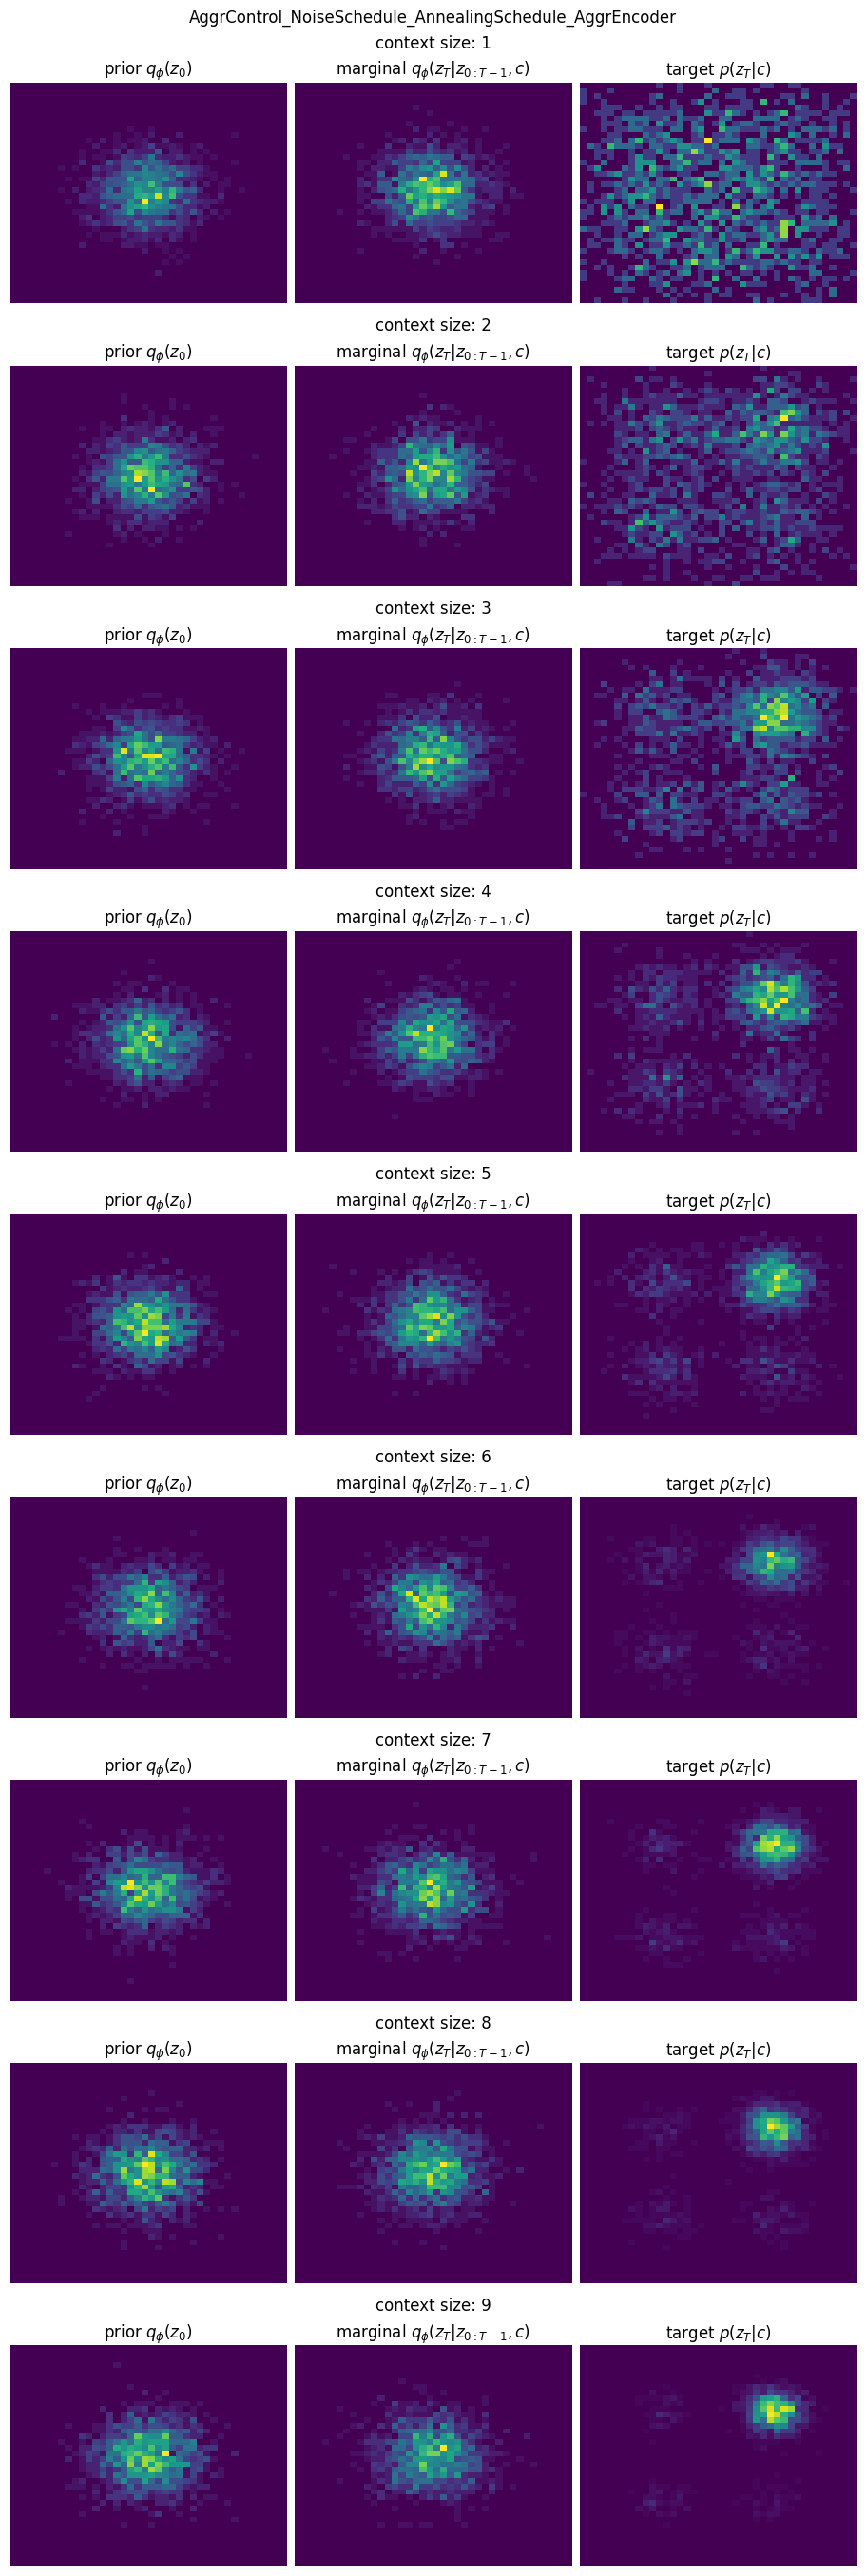

In [13]:
num_samples = 1600 # 8192
bins = 40
plot_range = [(-5, 5), (-5, 5)]
nrows = dataset.max_context_size - 1

context = dataset.sampling_factor * torch.rand((1, num_samples, nrows, config.c_dim), device=device)
context[:, :, :, 0] = context[:, :, :, 0] * 1
context[:, :, :, 1] = context[:, :, :, 1] * 1

fig = plt.figure(figsize=(9, 3 * nrows), constrained_layout=True)
subfigs = fig.subfigures(nrows=nrows, ncols=1)

id = "_".join([f"{obj.__class__.__name__}" for obj in comps])
fig.suptitle(id)

jsds = []

for row, subfig in enumerate(subfigs):

    subfig.suptitle(f"context size: {row + 1}")
    ax = subfig.subplots(nrows=1, ncols=3, width_ratios=[1, 1, 1])

    context_size = row + 1
    sub_context = context[:, :, :context_size, :] 
    
    target_dist = model.contextual_target(sub_context, None)
    
    r = model.encoder(sub_context.to(device), None)
    _, z_samples = model.cdvi.run_forward_process(target_dist, r, None, None)

    z_0_samples = z_samples[0].detach().cpu().numpy()
    z_T_samples = z_samples[-1].detach().cpu().numpy()
    z_trajectories = [[z[0, i, :].detach().cpu().numpy() for z in z_samples] for i in range(num_samples)]
    z_target_samples = target_dist.sample().detach().cpu().numpy()

    z_0_samples = z_0_samples.reshape(-1, z_0_samples.shape[-1])
    z_T_samples = z_T_samples.reshape(-1, z_T_samples.shape[-1])
    z_target_samples = z_target_samples.reshape(-1, z_target_samples.shape[-1])

    ax[0].hist2d(z_0_samples[:, 0], z_0_samples[:, 1], bins=bins, range=plot_range)
    ax[0].set_title("prior $q_\phi(z_0)$")

    ax[1].hist2d(z_T_samples[:, 0], z_T_samples[:, 1], bins=bins, range=plot_range)
    ax[1].set_title("marginal $q_\phi(z_T|z_{0:T-1},c)$")

    ax[2].hist2d(z_target_samples[:, 0], z_target_samples[:, 1], bins=bins, range=plot_range)
    ax[2].set_title("target $p(z_T|c)$")

    for a in ax:
        a.axis("off")

    # num_cells = int(np.sqrt(context.shape[1]))
    # grid = create_grid(plot_range, num_cells)

    # dvi_vals = eval_hist_on_grid(z_T_samples, plot_range, num_cells)
    # target_vals = eval_dist_on_grid(grid, target, device=device).squeeze(0)

    # jsd = compute_jsd(dvi_vals, target_vals)

    # jsds.append(jsd)

    # print(f"context size: {row + 1}, jsd: {jsd}, bd: {bd}")

# import pandas as pd

# df = pd.DataFrame({id: jsds}, index=[row + 1 for row in range(nrows)])
# print(df.head())

plt.show()

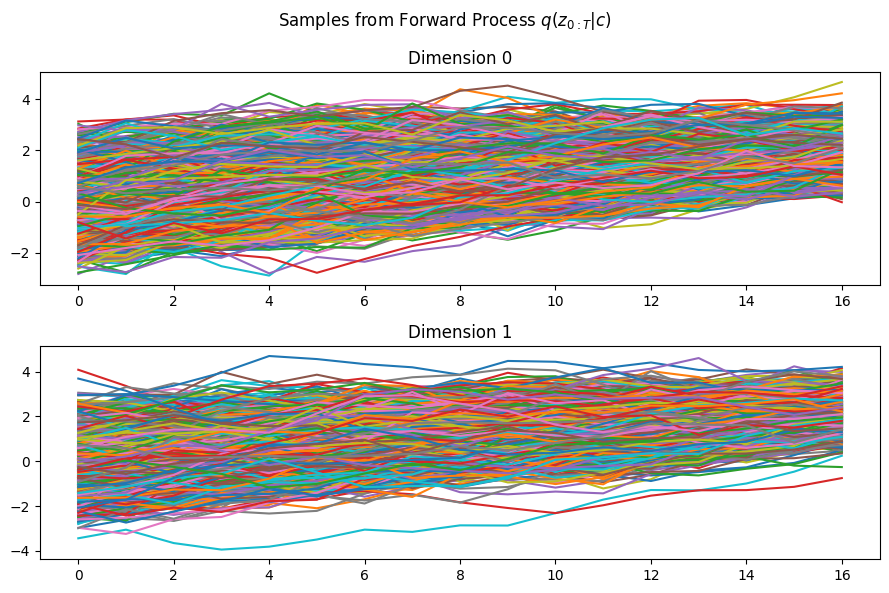

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(9, 6))

for i in range(num_samples):
    ax[0].plot([z[0] for z in z_trajectories[i]])
    ax[0].set_title("Dimension 0")

    ax[1].plot([z[1] for z in z_trajectories[i]])
    ax[1].set_title("Dimension 1")
    
plt.suptitle("Samples from Forward Process $q(z_{0:T}|c)$")

plt.tight_layout()
plt.show()

In [12]:
!jupyter nbconvert --to script exp_2d.ipynb

[NbConvertApp] Converting notebook exp_2d.ipynb to script
[NbConvertApp] Writing 9408 bytes to exp_2d.py
